# MPAS Ocean visualization

MPAS Ocean visualization notebook

***

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import sys
import yaml
from itertools import groupby
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from tqdm import tqdm

# Import modules from path
sys.path.append('../modules/')
import postprocesstools as pptools
import transecttools as trtools
import watermasstools as wmttools

plt.rcParams.update({'font.size': 14, 'axes.titlesize': 'medium'})

***

### Plot model variables

Define plotting requests

In [2]:
# 2D variable names
varNames2D = [
    'evaporationFlux',
    'rainFlux',
    'snowFlux',
    'riverRunoffFlux',
    'iceRunoffFlux',
    'seaIceFreshWaterFlux',
    'seaIceSalinityFlux',
    'salinitySurfaceRestoringTendency',
]

# 3D variable names
varNames3D = [
    'activeTracers_temperature',
    'activeTracers_salinity',
    'velocityZonal',
    'velocityMeridional',
]

# Bounding box
bbox = [-100, 20, 40, 80]

# Averaging depths
depths = [0, 20, 100, 500, 1000]

# Time index
startyear = 1947
years, months = np.arange(1, 11), np.arange(1, 13)
timeindex = [datetime(startyear + year, month, 1) for year in years for month in months]
timeindex = pd.Index(np.array(timeindex), name='time')

# Initialize variables storage
datasets, wmt = {}, {'LR': {}, 'HR': {}}

Get mesh variables, subdomain, and remapping params

In [3]:
meshName = 'LR'

# Get paths
with open(f'../yaml/paths_{meshName}.yaml') as f:
    paths = yaml.safe_load(f)
    
# Results prefix
prefix = paths['results']['1947-1957'] + '/' + paths['prefix']

# Load coords
coords, transectMasks, subdomain = pptools.load_coords(meshName)

# Remapping variables
remapvars = pptools.build_remapper(paths['meshfile'], bbox=bbox)

# Depth average indices
zindexes = {depth: abs(coords['refBottomDepth'] - depth).argmin() + 1 for depth in depths}
zmax = max(zindexes.values())

# Initialize dicts and lists
variables = {f'{varName}{depth}': [] for varName in varNames3D for depth in zindexes}
variables.update({varName: [] for varName in varNames2D})
wmt1D, wmt2D = [], []

# Sigmabin kwargs
sigma_kwargs = {'sigmarange': [27, 28.2], 'binsize': 0.01}

Load model variable fields

In [ ]:
# Load variables
for year in years:
    for month in tqdm(months, desc=f'Processing year {year}'):
        f = f'{prefix}.{year:04d}-{month:02d}-01.nc'
        with xr.open_dataset(f) as ds:
            for varName in varNames2D:
                variable = ds['timeMonthly_avg_' + varName][0, :].values[subdomain]
                variables[varName].append(variable)
            for varName in varNames3D:
                variable = ds['timeMonthly_avg_' + varName][0, :, :zmax].values[subdomain, :]
                for depth, zindex in zindexes.items():
                    variables[f'{varName}{depth}'].append(variable[:, :zindex].mean(axis=1))
            
            # Calculate water mass transformation
            S, T = [variables[f'activeTracers_{name}0'][-1] for name in ('salinity', 'temperature')]
            sigmaTheta, heatFactor, saltFactor = wmttools.calc_state_variables(S, T)
            fluxes = wmttools.build_combined_fluxes(ds, heatFactor, saltFactor, S, subdomain=subdomain)
            wmt1D.append(wmttools.calc_wmt(fluxes, sigmaTheta, coords, **sigma_kwargs, regions=coords['regionNames']))
            wmt2D.append(wmttools.calc_wmt(fluxes, sigmaTheta, coords, **sigma_kwargs, remapvars=remapvars))

# Concatenate
ds = []
for varName, values in variables.items():
    values = [pptools.remap(value, coords['nCells'], **remapvars) for value in values]
    da = xr.concat(values, timeindex)
    da.name = varName
    ds.append(da)
datasets[meshName] = xr.merge(ds)
wmt[meshName]['1D'] = xr.concat(wmt1D, timeindex)
wmt[meshName]['2D'] = xr.concat(wmt2D, timeindex)

***

### Vector plots LR

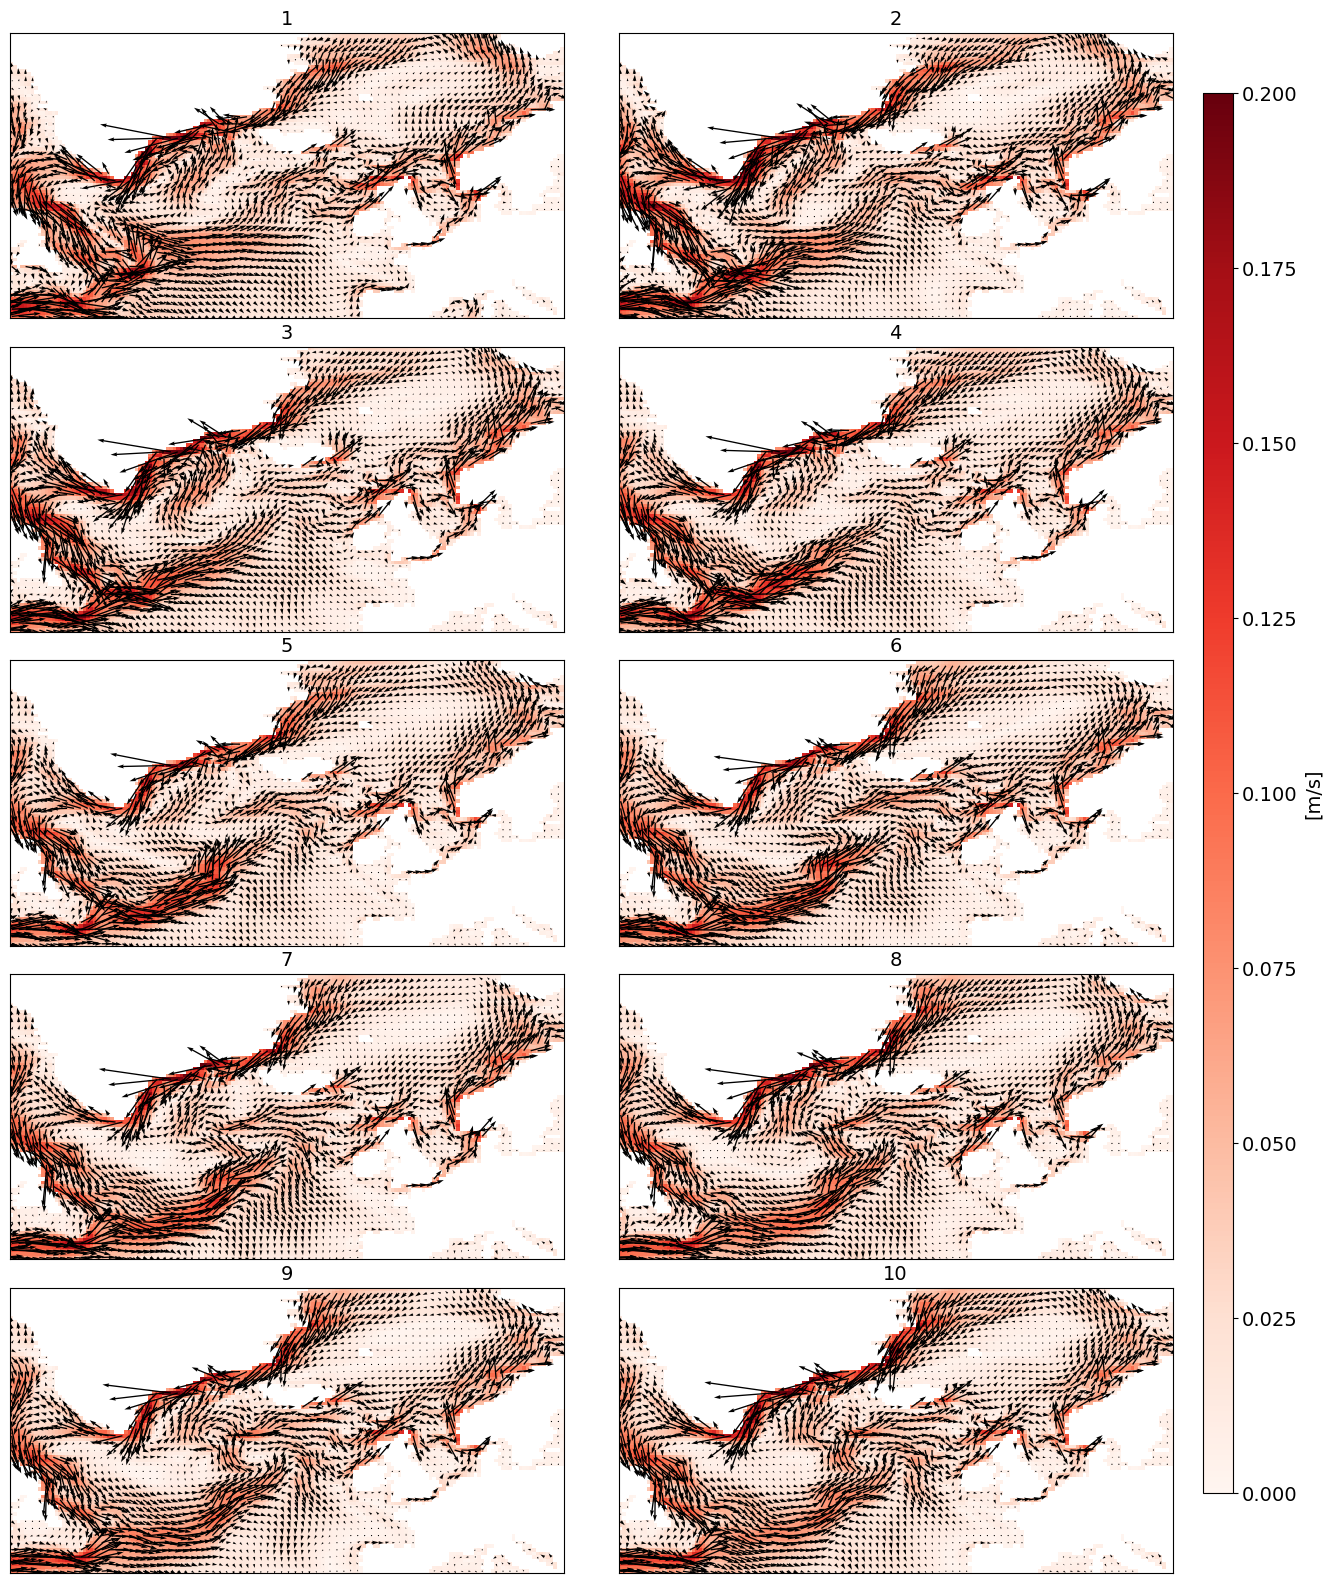

In [159]:
fig, axs = plt.subplots(5, 2, figsize=(15, 20), gridspec_kw={'hspace': 0.1, 'wspace': 0.1})

for ax, year in zip(axs.ravel(), range(10)):
    da_u = variables['velocityZonal'][year]
    da_v = variables['velocityMeridional'][year]
    da = np.sqrt(da_u**2 + da_v**2)
    c = ax.pcolormesh(da.lon, da.lat, da, vmin=0, vmax=0.2, cmap='Reds')
    q = ax.quiver(da.lon[::2], da.lat[::2], da_u[::2, ::2], da_v[::2, ::2], scale=2)
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    ax.set_xlim(-60, 20)
    ax.set_ylim(40, 80)
    ax.set_title(year+1)
cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(c, cax=cax, label='[m/s]')

***

### Vector plots HR

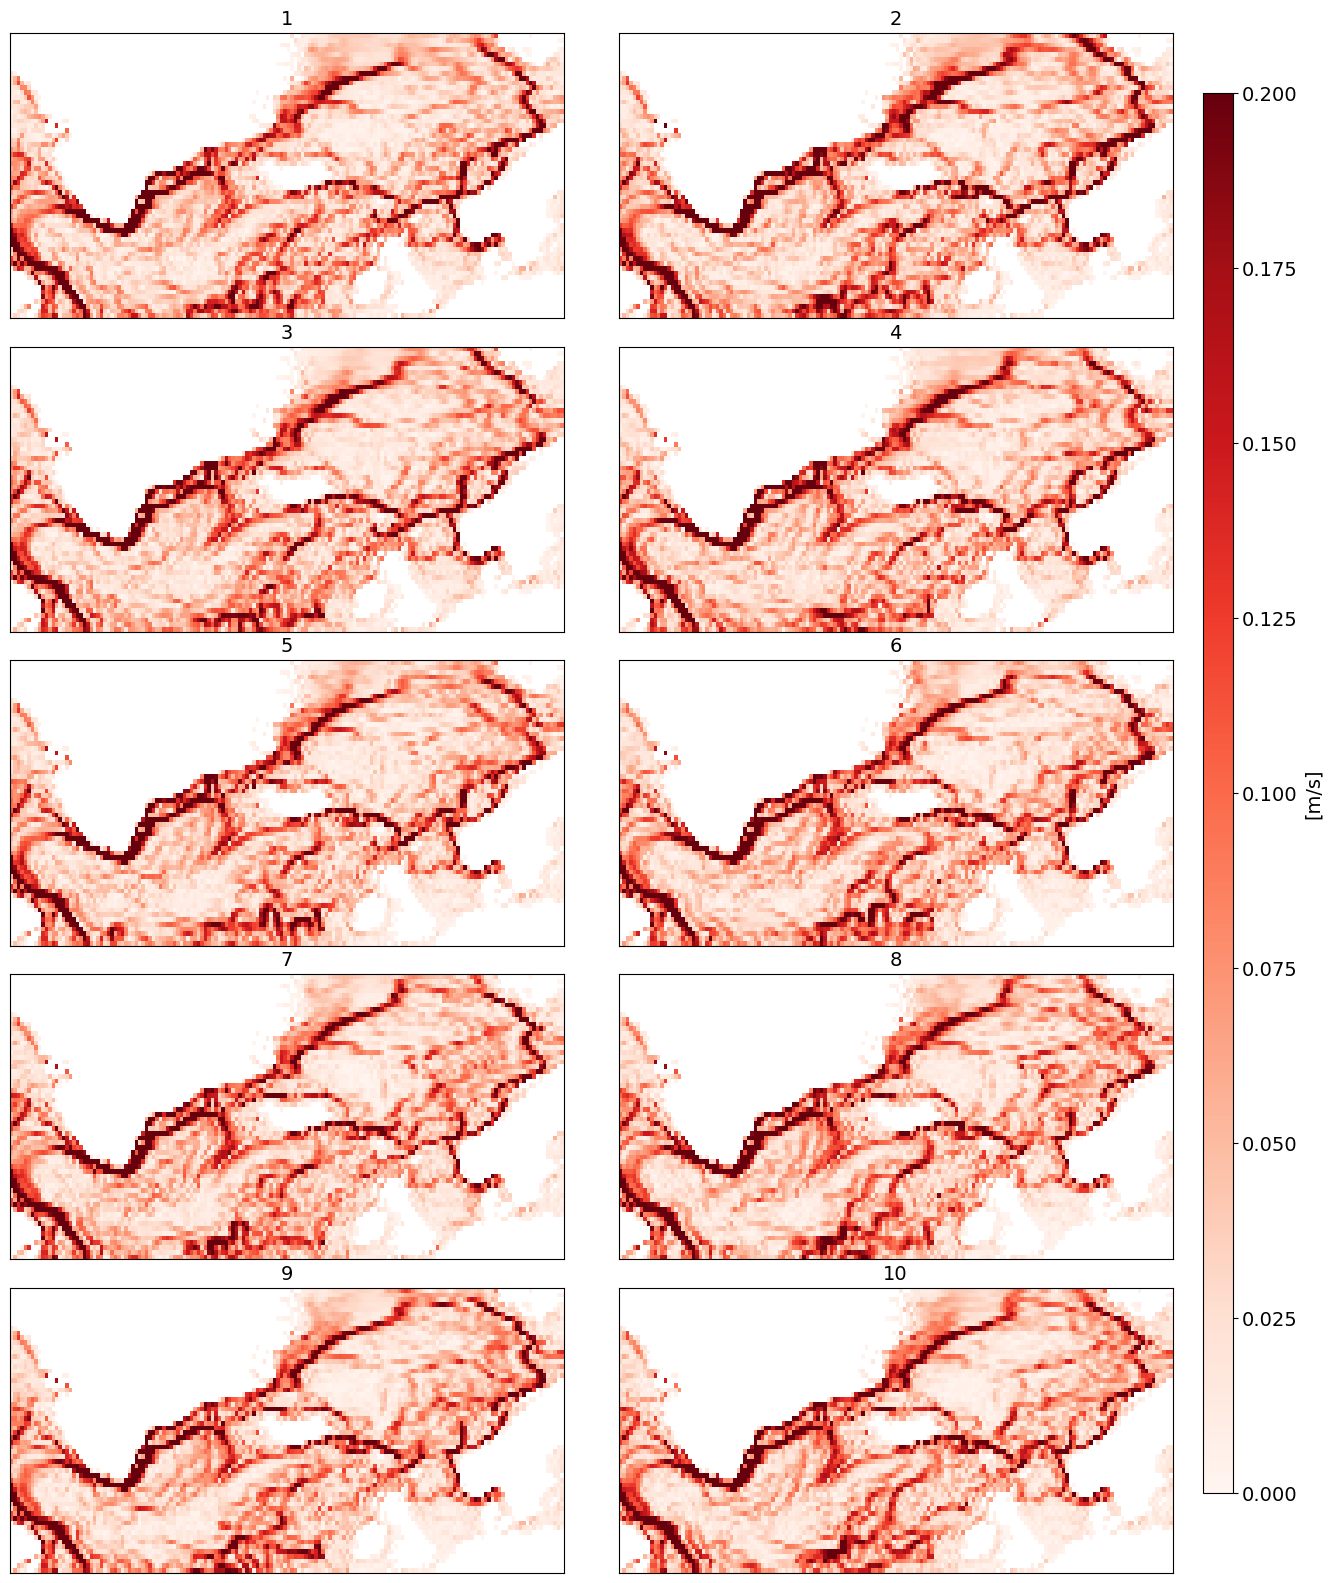

In [59]:
fig, axs = plt.subplots(5, 2, figsize=(15, 20), gridspec_kw={'hspace': 0.1, 'wspace': 0.1})

u = datasets['HR'].velocityZonal100.resample(time='1y').mean()
v = datasets['HR'].velocityMeridional100.resample(time='1y').mean()

for ax, year in zip(axs.ravel(), years):
    spd = np.sqrt(u[year-1, ...]**2 + v[year-1, ...]**2)
    c = ax.pcolormesh(spd.lon, spd.lat, spd, vmin=0, vmax=0.2, cmap='Reds')
    #q = ax.quiver(u.lon[::3], u.lat[::3], u[::3, ::3], v[::3, ::3], scale=2)
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    #ax.set_xlim(-60, 10)
    #ax.set_ylim(40, 65)
    ax.set_xlim(-60, 20)
    ax.set_ylim(50, 80)
    ax.set_title(year)
cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(c, cax=cax, label='[m/s]')